##### setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import numpy as np

def preprocess_turnover_data(turnover_trend):
    turnover_trend['year'] = pd.to_datetime(turnover_trend['recorddate_key']).dt.to_period('Y')

    turnover_trend.columns = [col.lower() for col in turnover_trend.columns]
    # get dummies for all categoricals, drop originals
    categorical_features = ['job_title', 'gender_short', 'termreason_desc', 'termtype_desc', 'business_unit',  'department_name']
    turnover_trend = pd.get_dummies(turnover_trend, columns=categorical_features, drop_first=False)
    turnover_trend.columns = [col.lower() for col in turnover_trend.columns]

    # 1 = voluntary turnover, 0 = stayed
    turnover_trend['voluntary_turnover'] = (turnover_trend['termreason_desc_resignaton'] == True).astype(int)

    # drop any unnecessary columns
    i=0
    drop_cols = ['termreason_desc_layoff',
                'termreason_desc_not applicable',
                'termreason_desc_resignaton',
                'termreason_desc_retirement',
                'termtype_desc_involuntary',
                'termtype_desc_not applicable',
                'termtype_desc_voluntary']

    for each in turnover_trend.dtypes:
        if each == 'object':
            drop_cols.append(turnover_trend.columns[i])
        i+=1

    # remove potential model by columns from drop_cols
    model_by_cols = ['city_name', 'store_name']
    drop_cols = [col for col in drop_cols if col not in model_by_cols]
    turnover_trend.drop(columns=drop_cols+['employeeid','status_year'], inplace=True)
    
    return turnover_trend

def yearify_features(df):
    """Convert features to yearly averages or sums as appropriate."""
    df = df.copy()
    df.drop(columns=['city_name', 'store_name'], inplace=True)
    df = df.groupby('year').mean(numeric_only=False)
    df['voluntary_turnover'] = df['voluntary_turnover']*100
    return df

def city_store_yearify(df):
    """Convert features to yearly averages or sums as appropriate."""
    df = df.copy()
    df = df.groupby(['year', 'city_name', 'store_name']).mean(numeric_only=False)
    df.reset_index(inplace=True)
    df.set_index(['year'], inplace=True)
    df['voluntary_turnover'] = df['voluntary_turnover']*100
    return df

def load_and_process_data():
    turnover_trend = pd.read_csv("../data/10yr_turnover.csv")
    turnover_trend.columns = [col.lower() for col in turnover_trend.columns]
    economic_data = pd.read_excel("../data/economic_data.xlsx", sheet_name='annual_data')
    turnover_trend = turnover_trend.merge(economic_data, how='left', left_on='status_year', right_on='year')

    preprocessed_turnover_trend = preprocess_turnover_data(turnover_trend)
    year_df = yearify_features(preprocessed_turnover_trend)
    city_store_yr_df = city_store_yearify(preprocessed_turnover_trend)

    city_store_yr_df = pd.get_dummies(city_store_yr_df, columns=['city_name', 'store_name'], drop_first=False)

    # Fix column names to remove special characters that cause issues with LightGBM
    city_store_yr_df.columns = city_store_yr_df.columns.str.replace('[^A-Za-z0-9_]', '_', regex=True)
    city_store_yr_df.columns = city_store_yr_df.columns.str.replace('__+', '_', regex=True)
    city_store_yr_df.columns = city_store_yr_df.columns.str.strip('_')

    X = city_store_yr_df.drop(['voluntary_turnover'], axis=1)
    y = city_store_yr_df['voluntary_turnover']  # Use actual percentage values
    return X, y

def select_top_features(X, y):
    X = X.copy()
    from sklearn.ensemble import RandomForestRegressor

    keep_cols = []
    for col in X.columns:
        if 'city_name' in col:
            keep_cols.append(col)
        if 'store_name' in col:
            keep_cols.append(col)

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)

    top_features = feature_importance.head(30)['feature'].tolist()
    columns_to_keep = set(keep_cols).union(set(top_features))
    X = X[list(columns_to_keep)]
    return X

def fit_model(X, y):
    import lightgbm as lgb
    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define hyperparameter grid for LightGBM
    param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [2,3],
        'learning_rate': [0.05, 0.1],
        'num_leaves': [15, 30],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'reg_alpha': [0, 0.1, 0.5],
        'reg_lambda': [0.1, 1.0, 2.0]
    }

    # Create LightGBM regressor
    lgb_model = lgb.LGBMRegressor(random_state=42, verbose=-1)

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(
        estimator=lgb_model,
        param_grid=param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )

    # Fit the grid search
    grid_search.fit(X_train, y_train)
    best_lgbm_model = grid_search.best_estimator_

    # Make predictions
    y_pred = best_lgbm_model.predict(X_test)

    # Calculate metrics
    train_score = best_lgbm_model.score(X_train, y_train)
    test_score = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    print("Best LightGBM Model Results:")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV R² score: {grid_search.best_score_:.4f}")
    print(f"Training R²: {train_score:.4f}")
    print(f"Test R²: {test_score:.4f}")
    print(f"Test MSE: {mse:.4f}")
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"R² difference (train - test): {train_score - test_score:.4f}")

    if abs(train_score - test_score) > 0.1:
        print("Warning: Potential overfitting detected!")
    else:
        print("Model appears to generalize well.")
    
    return best_lgbm_model

def get_shap(best_lgbm_model, X):
    # import shap
    import shap
    # Initialize SHAP explainer
    explainer = shap.TreeExplainer(best_lgbm_model)
    shap_values = explainer.shap_values(X)
    shap_values = pd.DataFrame(shap_values, columns=X.columns)
    shap.summary_plot(shap_values.values, X, plot_type="bar", max_display=10)
    shap.summary_plot(shap_values.values, X)
    return shap_values

# city / store / year model

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Best LightGBM Model Results:
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'num_leaves': 15, 'reg_alpha': 0.1, 'reg_lambda': 2.0, 'subsample': 0.8}
Best CV R² score: 0.0881
Training R²: 0.5403
Test R²: 0.2156
Test MSE: 1.0455
Test RMSE: 1.0225
Test MAE: 0.6774
R² difference (train - test): 0.3247


/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


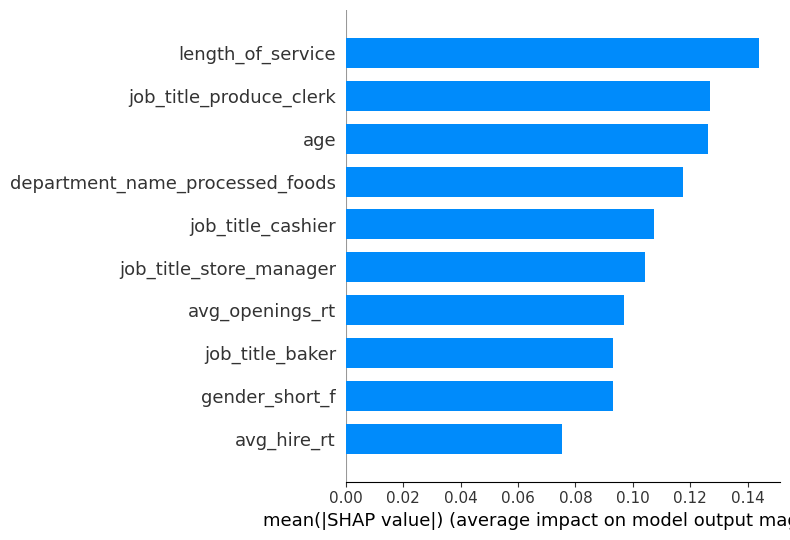

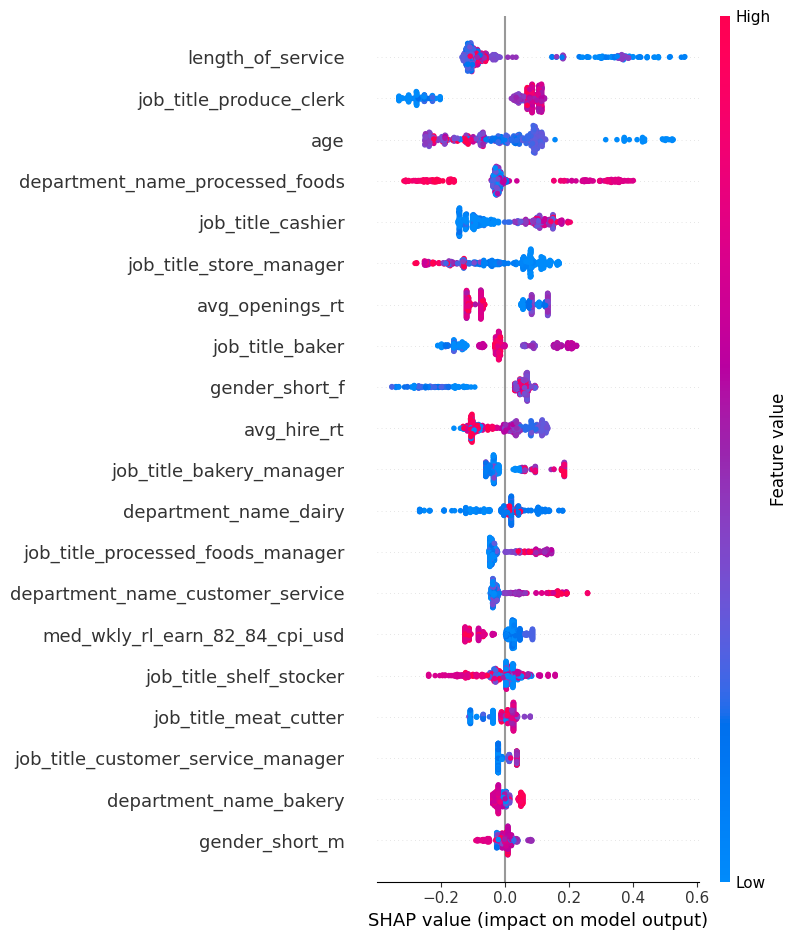

In [2]:
X, y = load_and_process_data()
X = select_top_features(X, y)
best_lgbm_model = fit_model(X, y)

shap_values = get_shap(best_lgbm_model, X)

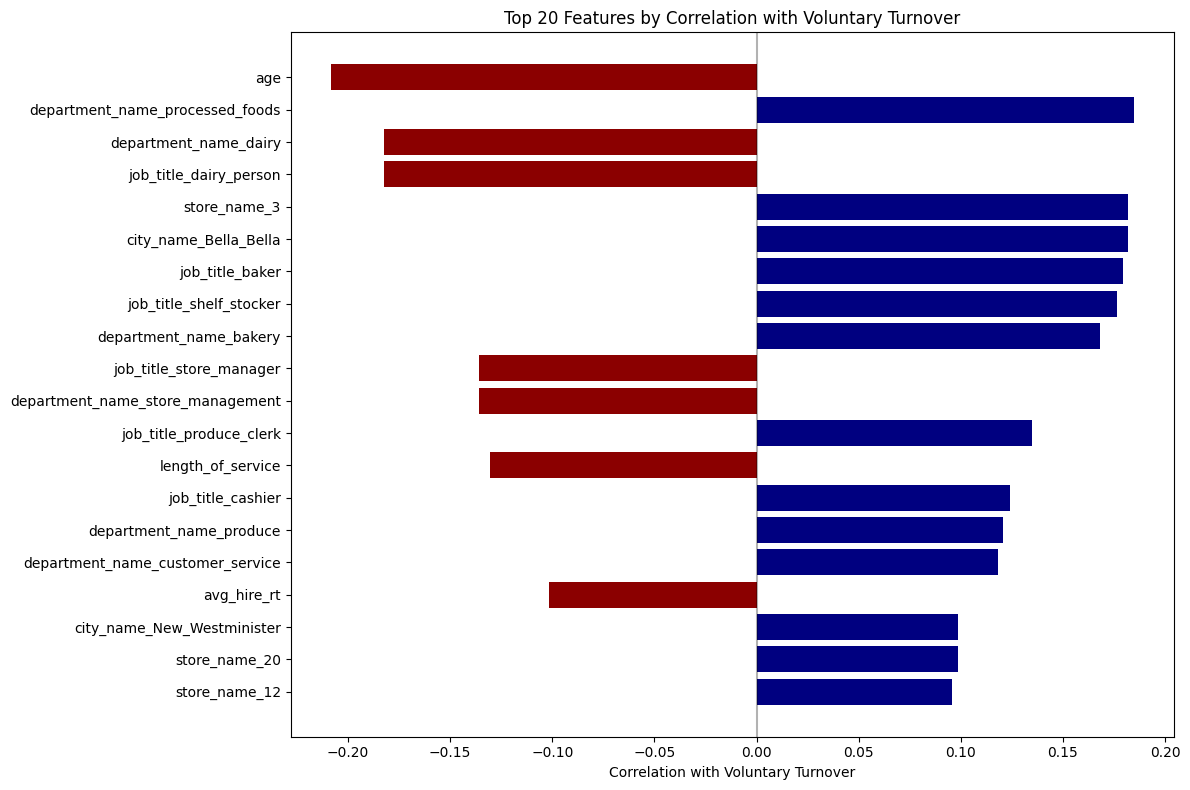

Top 20 correlations:
                              feature  correlation
98                                age    -0.208345
83    department_name_processed_foods     0.184659
31              department_name_dairy    -0.182224
52             job_title_dairy_person    -0.182215
97                       store_name_3     0.181913
93              city_name_Bella_Bella     0.181913
73                    job_title_baker     0.179303
47            job_title_shelf_stocker     0.176288
96             department_name_bakery     0.168034
72            job_title_store_manager    -0.135710
87   department_name_store_management    -0.135710
86            job_title_produce_clerk     0.134630
13                  length_of_service    -0.130496
53                  job_title_cashier     0.124279
75            department_name_produce     0.120789
4    department_name_customer_service     0.118300
32                        avg_hire_rt    -0.101618
22         city_name_New_Westminister     0.098851
104       

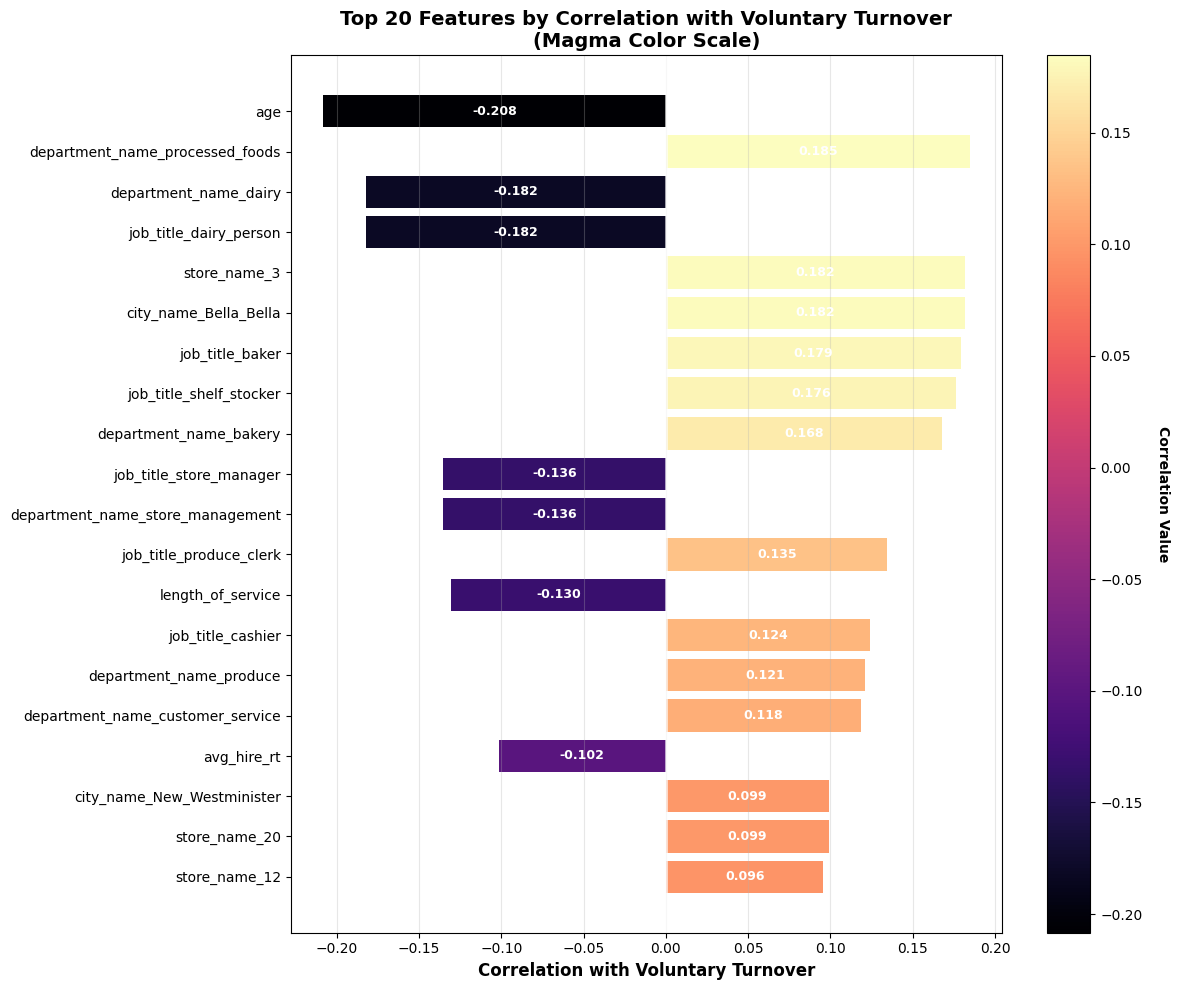

In [3]:
# Calculate correlations between features and target variable
correlations = pd.DataFrame({
    'feature': X.columns,
    'correlation': [X[col].corr(y) for col in X.columns]
}).sort_values('correlation', key=abs, ascending=False)

# Remove NaN correlations (if any)
correlations = correlations.dropna()

# Plot the top 20 strongest correlations
plt.figure(figsize=(12, 8))
top_correlations = correlations.head(20)
colors = ['#8B0000' if x < 0 else '#000080' for x in top_correlations['correlation']]
plt.barh(range(len(top_correlations)), top_correlations['correlation'], color=colors)
plt.yticks(range(len(top_correlations)), top_correlations['feature'])
plt.xlabel('Correlation with Voluntary Turnover')
plt.title('Top 20 Features by Correlation with Voluntary Turnover')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Display the correlation values
print("Top 20 correlations:")
print(correlations.head(20))

# Print the bottom 20 correlations (weakest)
print("\nBottom 20 correlations (weakest):")
print(correlations.tail(20))

# Create a second plot with improved styling
plt.figure(figsize=(12,10))
top_correlations = correlations.head(20)

# Use magma colormap - map correlation values to colors
import matplotlib.cm as cm
norm = plt.Normalize(vmin=top_correlations['correlation'].min(), vmax=top_correlations['correlation'].max())
colors = cm.magma(norm(top_correlations['correlation']))

# Create horizontal bar plot
bars = plt.barh(range(len(top_correlations)), top_correlations['correlation'], color=colors)

# Add value labels on each bar (centered)
for i, (bar, corr_val) in enumerate(zip(bars, top_correlations['correlation'])):
    plt.text(corr_val / 2, i, f'{corr_val:.3f}', 
             va='center', ha='center', fontsize=9, fontweight='bold', color='white')

plt.yticks(range(len(top_correlations)), top_correlations['feature'], fontsize=10)
plt.xlabel('Correlation with Voluntary Turnover', fontsize=12, fontweight='bold')
plt.title('Top 20 Features by Correlation with Voluntary Turnover\n(Magma Color Scale)', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='white', linestyle='-', alpha=0.7, linewidth=2)
plt.gca().invert_yaxis()

# Add colorbar
sm = cm.ScalarMappable(cmap=cm.magma, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('Correlation Value', rotation=270, labelpad=20, fontweight='bold')

plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [4]:
# Get all store name columns that are True and sum them
store_columns = [col for col in X.columns if col.startswith('store_name')]

In [5]:
vancX = X[X['city_name_Vancouver'] == True]


In [10]:

vanc_store_44 = vancX[vancX['store_name_44'] == True]
vanc_store_44.index == '2015'

array([False, False, False, False, False, False, False, False, False,
        True])

In [9]:
vanc_store_44

,store_name_10,store_name_44,store_name_33,store_name_16,department_name_customer_service,city_name_Cranbrook,store_name_15,city_name_Aldergrove,store_name_24,city_name_Victoria,...,city_name_Chilliwack,store_name_13,store_name_20,store_name_14,job_title_produce_manager,city_name_Fort_St_John,city_name_West_Vancouver,city_name_Terrace,store_name_34,city_name_Trail
year,,,,,,,,,,,,,,,,,,,,,
2006,False,True,False,False,0.142857,False,False,False,False,False,...,False,False,False,False,0.142857,False,False,False,False,False
2007,False,True,False,False,0.142857,False,False,False,False,False,...,False,False,False,False,0.142857,False,False,False,False,False
2008,False,True,False,False,0.029412,False,False,False,False,False,...,False,False,False,False,0.029412,False,False,False,False,False
2009,False,True,False,False,0.011236,False,False,False,False,False,...,False,False,False,False,0.011236,False,False,False,False,False
2010,False,True,False,False,0.007634,False,False,False,False,False,...,False,False,False,False,0.007634,False,False,False,False,False
2011,False,True,False,False,0.005291,False,False,False,False,False,...,False,False,False,False,0.005291,False,False,False,False,False
2012,False,True,False,False,0.108434,False,False,False,False,False,...,False,False,False,False,0.004016,False,False,False,False,False
2013,False,True,False,False,0.218638,False,False,False,False,False,...,False,False,False,False,0.003584,False,False,False,False,False
2014,False,True,False,False,0.216117,False,False,False,False,False,...,False,False,False,False,0.003663,False,False,False,False,False


In [8]:
# Find Vancouver data for store 44
vanc_store_44 = vancX[vancX['store_name_44'] == True]
print(f"Available years for Vancouver store 44: {vanc_store_44.index.tolist()}")

if len(vanc_store_44) > 0:
    # Get the most recent year available for this store
    latest_year = vanc_store_44.index.max()
    
    # Find the integer index in the original X DataFrame that corresponds to this row
    matching_rows = X[(X['city_name_Vancouver'] == True) & (X['store_name_44'] == True)]
    matching_rows = matching_rows[matching_rows.index == latest_year]
    
    if len(matching_rows) > 0:
        # Get the integer position of this row in X
        row_position = X.index.get_loc(matching_rows.index[0])
        
        print(f"Using data from year: {latest_year}")
        print(f"Row position in dataset: {row_position}")
        
        # Get SHAP values for this specific observation using integer position
        store_44_shap_values = shap_values.iloc[row_position].values
        
        # Get the feature values for this observation
        feature_values = X.iloc[row_position].values
        
        # Create waterfall plot - note the corrected syntax
        shap.plots.waterfall(
            shap.Explanation(
                values=store_44_shap_values,
                base_values=shap_values.mean().mean(),  # Use mean SHAP value as base
                data=feature_values,
                feature_names=X.columns.tolist()
            ),
            max_display=15
        )
    else:
        print(f"No matching row found for year {latest_year}")
else:
    print("No data found for Vancouver store 44")
    print("Available Vancouver stores:")
    for col in vancX.columns:
        if col.startswith('store_name_') and vancX[col].any():
            print(f"  {col}")


Available years for Vancouver store 44: [Period('2006', 'Y-DEC'), Period('2007', 'Y-DEC'), Period('2008', 'Y-DEC'), Period('2009', 'Y-DEC'), Period('2010', 'Y-DEC'), Period('2011', 'Y-DEC'), Period('2012', 'Y-DEC'), Period('2013', 'Y-DEC'), Period('2014', 'Y-DEC'), Period('2015', 'Y-DEC')]
Using data from year: 2015
Row position in dataset: slice(414, 452, None)


ValueError: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (38, 112)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.

In [ ]:
shap_values[(shap_values['city_name_Vancouver'] == 1) & (shap_values['store_name_'] == 44)]

KeyError: 'store_name_'